In [1]:
from Bio import SeqIO
import pandas as pd
from Bio.Seq import Seq
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from scipy.stats import mannwhitneyu,ttest_ind,spearmanr
path_real = "/home/chensa/gb_data/data_for_analysis/part2/"
codons_table = {
        'TTT': 'F', 'CTT': 'L', 'ATT': 'I', 'GTT': 'V',
        'TTC': 'F', 'CTC': 'L', 'ATC': 'I', 'GTC': 'V',
        'TTA': 'L', 'CTA': 'L', 'ATA': 'I', 'GTA': 'V',
        'TTG': 'L', 'CTG': 'L', 'ATG': 'M', 'GTG': 'V',
        'TCT': 'S', 'CCT': 'P', 'ACT': 'T', 'GCT': 'A',
        'TCC': 'S', 'CCC': 'P', 'ACC': 'T', 'GCC': 'A',
        'TCA': 'S', 'CCA': 'P', 'ACA': 'T', 'GCA': 'A',
        'TCG': 'S', 'CCG': 'P', 'ACG': 'T', 'GCG': 'A',
        'TAT': 'Y', 'CAT': 'H', 'AAT': 'N', 'GAT': 'D',
        'TAC': 'Y', 'CAC': 'H', 'AAC': 'N', 'GAC': 'D',
        'TAA': '*', 'CAA': 'Q', 'AAA': 'K', 'GAA': 'E',
        'TAG': '*', 'CAG': 'Q', 'AAG': 'K', 'GAG': 'E',
        'TGT': 'C', 'CGT': 'R', 'AGT': 'S', 'GGT': 'G',
        'TGC': 'C', 'CGC': 'R', 'AGC': 'S', 'GGC': 'G',
        'TGA': '*', 'CGA': 'R', 'AGA': 'R', 'GGA': 'G',
        'TGG': 'W', 'CGG': 'R', 'AGG': 'R', 'GGG': 'G'
    }
stops = set(["TAA","TAG","TGA"])
os.chdir(path_real)

Riboseq_TPM.csv, RNAseqL19_TPM.tsv come from sheet 'Riboseq_TPM' and 'RNAseqL29_TPM' of 1-s2.0-S1097276522006062-mmc4.xlsx

In [ ]:
df1 = pd.read_csv("Riboseq_TPM.csv")
df2 = pd.read_csv("RNAseqL19_TPM.csv")
df1 = df1.drop(columns=['SM'])
df2 = df2.drop(columns=['SM'])
ensg2expr = {}
with open("TE2.tsv", "w") as w:
    for row in df1.iterrows():
        ensg = row[1][0]
        # if ensg not in ms_ncORF:continue
        tpms_ribo = np.array([float(x) for x in row[1][1:]])
        tpms_rna = np.array([float(x) for x in df2[df2['ENSG'] == ensg].values[0][1:]])
        tpms = tpms_ribo / tpms_rna
        tpms[np.isnan(tpms)] = np.nan
        tpms[np.isinf(tpms)] = np.nan
        w.write(ensg + "\t" + "\t".join([str(_) for _ in tpms]) + "\n")

In [2]:
id2all = pickle.load(open("../mRNA/mRNA_id2all.pkl", "rb"))
name2lens = {}
for k,v in id2all.items():
    utr_len = v['start']
    if utr_len < 6:continue
    name2lens[k] = utr_len

In [3]:
records = list(SeqIO.parse("../mRNA/MANE.GRCh38.v1.3.ensembl_rna.fna", "fasta"))
with open("../mRNA/Enst_Ensg_Symbol.txt", 'w') as w:
    for rec in records:
        desp = str(rec.description)
        enst = desp.split(".")[0]
        ensg = desp.split("gene:")[1].split(".")[0]
        symbol = desp.split("gene_symbol:")[1].split()[0]
        w.write(f"{enst}\t{ensg}\t{symbol}\n")

In [4]:
df = pd.read_csv("../mRNA/Enst_Ensg_Symbol.txt", sep="\t", header=None)
enst2ensg = {}; ensg2enst = {}
for enst,ensg in zip(df[0],df[1]):
    enst2ensg[enst] = ensg
    ensg2enst[ensg] = enst

In [5]:
df = pd.read_csv('TE2.tsv',sep='\t')
name2expr = {}
for row in df.iterrows():
    tmps = np.array([float(x) for x in row[1][1:]])
    tmps = [_ for _ in tmps if _ == _]
    if row[1][0] in ensg2enst:
        enst = ensg2enst[row[1][0]]
        name2expr[enst] = np.mean(tmps)
name2expr['ENST00000328801']

/home/chensa/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/chensa/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1.1049606664402543

In [6]:
expr = []
lens = []
high_utr = []; low_utr = []
long_expr = [];long_lens = []
hu_expr = [];hu_lens_ori = []
lu_expr = [];lu_lens_ori = []
for k,v in name2expr.items():
    if v!=v: continue
    if k not in name2lens: continue
    # expr.append(v)
    # lens.append(name2lens[k])
    if name2lens[k] > 596:
        long_expr.append(v); long_lens.append(name2lens[k])
        if v > 0.798:
            high_utr.append(k)
            hu_expr.append(v); hu_lens_ori.append(name2lens[k])
        elif v < 0.4368:
            low_utr.append(k)
            lu_expr.append(v); lu_lens_ori.append(name2lens[k])
        else:
            expr.append(v)
            lens.append(name2lens[k])
    else:
        expr.append(v)
        lens.append(name2lens[k])
expr_log = np.log10(np.array(expr)+1)
lens_log = np.log10(np.array(lens)+1)
long_expr_log = np.log10(np.array(long_expr)+1); long_lens_log = np.log10(np.array(long_lens)+1)
hu_expr_log = np.log10(np.array(hu_expr)+1); hu_lens_ori_log = np.log10(np.array(hu_lens_ori)+1)
lu_expr_log = np.log10(np.array(lu_expr)+1); lu_lens_ori_log = np.log10(np.array(lu_lens_ori)+1)

In [7]:
np.quantile(expr,0.5), np.quantile(expr,0.25), np.quantile(lens,0.95), len(high_utr), len(low_utr), spearmanr(expr,lens)

(0.8068273019598164,
 0.4537207378420599,
 476.0,
 265,
 415,
 SignificanceResult(statistic=-0.18923685397027729, pvalue=1.423593223633437e-140))

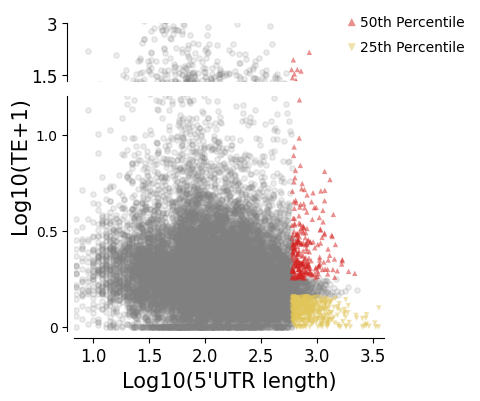

In [8]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(4, 4))
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 4], hspace=0.1)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.scatter(lens_log, expr_log, marker='o', alpha=0.15, s=15,color = 'grey')
# ax1.scatter(long_lens_log, long_expr_log, marker='o', alpha=0.5, s=15, color='#e1c559')
ax1.scatter(hu_lens_ori_log, hu_expr_log, marker='^', alpha=0.5, s=15, color='#d42221',edgecolors='none')
ax1.scatter(lu_lens_ori_log, lu_expr_log, marker='v', alpha=0.5, s=15, color='#e1c559',edgecolors='none')
ax1.set_ylim(1.2, 3)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(True)
ax1.spines['left'].set_position(('outward', 5))
ax1.set_xticks([])
ax1.set_yticks([1.4,3])
ax1.set_yticklabels([1.5,3], fontsize=12)
ax2.scatter(lens_log, expr_log, marker='o', alpha=0.15, s=15,color = 'grey')
# ax2.scatter(long_lens_log, long_expr_log, marker='o', alpha=0.5, s=15, color='#e1c559')
ax2.scatter(hu_lens_ori_log, hu_expr_log, marker='^', alpha=0.5, s=15, color='#d42221',label="50th Percentile",edgecolors='none')
ax2.scatter(lu_lens_ori_log, lu_expr_log, marker='v', alpha=0.5, s=15, color='#e1c559',label="25th Percentile",edgecolors='none')
ax2.set_ylim(-0.02, 1.2)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)
ax2.spines['left'].set_position(('outward', 5))
ax2.spines['bottom'].set_position(('outward', 5))
ax2.set_xlim(0.83, 3.6)
ax2.set_xticks([1.0,1.5,2.0,2.5,3.0,3.5])
ax2.set_xticklabels([1.0,1.5,2.0,2.5,3.0,3.5], fontsize=12)
_ = ax2.set_yticks([0,0.5,1.0])
_ = ax2.set_yticklabels([0,0.5,1.0], fontsize=10)
ax2.set_xlabel("Log10(5'UTR length)", fontsize=15)
ax2.set_ylabel("Log10(TE+1)", fontsize=15,loc='top')
ax2.legend(
    loc='upper right',
    bbox_to_anchor=(1.3, 1.4),
    fontsize=10,
    frameon=False,
    labelspacing=0.8, 
    handletextpad=0,  
    handlelength=1.2,
    markerscale=1.5
)
plt.savefig("../figures/" + "utr_expr.png", bbox_inches='tight',format='png', dpi=300)

In [9]:
kozak1 = "GCCACCATGG"
kozak2 = "GCCGCCATGG"
def get_dist(koz):
    dist = 0
    for a,b,c in zip(koz,kozak1,kozak2):
        if a != b and a != c:
            dist += 1
    return dist

hu_kozak_dist = []; lu_kozak_dist = []
for k in high_utr:
    if k not in id2all:print("err")
    if id2all[k]['start'] < 6:continue
    kozak = id2all[k]['rna'][id2all[k]['start']-6:id2all[k]['start']+4]
    hu_kozak_dist.append(get_dist(kozak))
for k in low_utr:
    if k not in id2all:print("err")
    if id2all[k]['start'] < 6:continue
    kozak = id2all[k]['rna'][id2all[k]['start']-6:id2all[k]['start']+4]
    lu_kozak_dist.append(get_dist(kozak))

In [10]:
from collections import Counter
hu_counts = dict(Counter(hu_kozak_dist))
hu_counts = {k: v/sum(hu_counts.values()) for k,v in hu_counts.items()}
lu_counts = dict(Counter(lu_kozak_dist))
lu_counts = {k: v/sum(lu_counts.values()) for k,v in lu_counts.items()}

all_distances = sorted(set(hu_counts) | set(lu_counts))

hu_values = [hu_counts.get(d, 0) for d in all_distances]
lu_values = [lu_counts.get(d, 0) for d in all_distances]

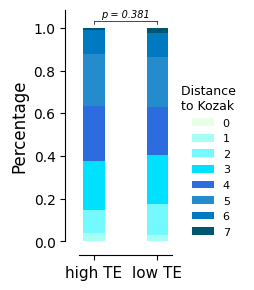

In [23]:
data = {
    'high TE': hu_values,
    'low TE': lu_values,
}
x = [1, 1.06,]

fig, ax = plt.subplots(figsize=(1.2, 3))
colors = ["#e8ffe8", "#a6fff2", "#74f9ff", "#00e0ff", "#2d6cdf","#248bcc", "#0079c1","#005670", "#00205b", "#000000"]
# Plot the stacked bar chart

for i in range(0,len(hu_values)):
    ax.bar(x[0], hu_values[i], width=0.02, bottom=sum(hu_values[:i]), color=colors[i], label=f'{i}')
    ax.bar(x[1], lu_values[i], width=0.02, bottom=sum(lu_values[:i]), color=colors[i])


plt.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.legend(bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0,fontsize=8, title='Distance \nto Kozak', title_fontsize=9,frameon=False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))

ax.set_xticks([1,1.06])
ax.set_xticklabels(['high TE', 'low TE'], fontsize=11)

ax.plot([x[0], x[1]], [1.03,1.03], color='black', lw=0.5)
ax.plot([x[0], x[0]], [1.02,1.03], color='black', lw=0.5)
ax.plot([x[1], x[1]], [1.02,1.03], color='black', lw=0.5)
ax.set_ylabel('Percentage', fontsize=12)
value,p = mannwhitneyu(hu_kozak_dist, lu_kozak_dist,alternative='greater')
plt.annotate(f'p = {p:.3f}', xy=(0.5, 0.97), xycoords='axes fraction',
             ha='center', fontsize=7, style='italic')

plt.savefig(f"./figures/"+"kozak_distance.pdf", format='pdf', bbox_inches='tight')

In [22]:
value

55730.0

In [24]:
path_egy = '/home/chensa/gb_data/data_for_analysis/energy'

import re
pattern = r'\(\s*(-?\d+\.\d+)\s*\)'
enst2egy = {}
with open(f"{path_egy}/res_mRNA_d50", "r") as file:
    for q in file:
        if '>' in q:
            enst = q.rstrip()[1:].split('_')[0]
        if '.' in q:
            enst2egy[enst] = float(re.search(pattern, q).group(1))


In [25]:
hu_egy = [enst2egy[k] for k in high_utr if k in enst2egy]
lu_egy = [enst2egy[k] for k in low_utr if k in enst2egy]

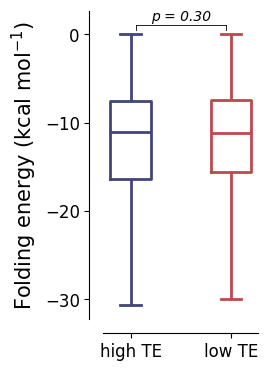

In [28]:
data = pd.DataFrame({'group': ['high TE'] * len(hu_egy) + ['low TE'] * len(lu_egy),
                     'energy': hu_egy + lu_egy})

plt.figure(figsize=(2, 4))

sns.boxplot(data=data[data['group'] == 'high TE'], x='group', y='energy', 
            color='#424577', width=0.4, showfliers=False, linewidth=2,fill=False,
            dodge=False, whis=100)
sns.boxplot(data=data[data['group'] == 'low TE'], x='group', y='energy', 
            color='#bd484d', width=0.4, showfliers=False, linewidth=2,fill=False,
            dodge=False, whis=100)
positions = [0, 1]
ax = plt.gca()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(ticks=positions, labels=['high TE', 'low TE',], fontsize=12)
plt.yticks([-30,-20,-10,0], fontsize=12)

t_statistic, p_value = ttest_ind(hu_egy, lu_egy)
p_value = p_value / 2 if t_statistic < 0 else 1 - p_value / 2
plt.plot([0.05, 0.95], [1,1], color='black', lw=0.6);plt.plot([0.05, 0.05], [0.5,1], color='black', lw=0.6);plt.plot([0.95, 0.95], [0.5,1], color='black', lw=0.6)
plt.annotate(f'p = {p_value:.2f}', xy=(0.5, 0.97), xycoords='axes fraction',
             ha='center', fontsize=10, style='italic')


plt.xlabel("")
plt.ylabel("Folding energy (kcal mol$^{-1}$)", fontsize=15)
sns.despine()

plt.savefig(f"{path_real}figures/"+'energy.pdf', dpi=300, format="pdf", bbox_inches='tight')
plt.show()


In [29]:
def get_uorf_cnt(utr_seq, near = False):
    starts = set(['ATG'])
    if near:
        starts.add('GTG');starts.add('TTG');starts.add('CTG')
    cnt = 0
    for utr in [utr_seq, utr_seq[1:], utr_seq[2:]]:
        aa = ""
        for i in range(0,len(utr)-2,3):
            codon = utr[i:i+3]
            if codon in starts and aa == "":
                aa = codons_table[codon]
                continue
            if aa != "":
                if codon in stops:
                    cnt += 1
                    aa = ""
                else:
                    aa += codons_table[codon]
        if aa != "":
            cnt += 1
    return cnt


hu_uorf_cnt_ori = []
for k in high_utr:
    utr = id2all[k]['rna'][:id2all[k]['start']-4]
    hu_uorf_cnt_ori.append(get_uorf_cnt(utr, near=True))
lu_uorf_cnt_ori = []
for k in low_utr:
    utr = id2all[k]['rna'][:id2all[k]['start']-4]
    # if len(utr)>2000:continue
    lu_uorf_cnt_ori.append(get_uorf_cnt(utr, near=True))
hu_uorf_atg = list(np.log(np.array(hu_uorf_cnt_ori)+1))
lu_uorf_atg = list(np.log(np.array(lu_uorf_cnt_ori)+1))

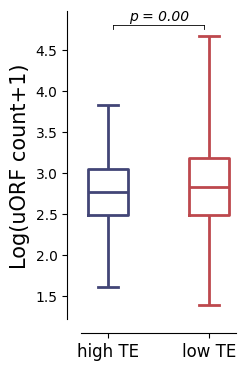

In [33]:
data = pd.DataFrame({'group': ['high TE'] * len(hu_uorf_atg) + ['low TE'] * len(lu_uorf_atg),
                        'uORF': hu_uorf_atg + lu_uorf_atg})
plt.figure(figsize=(2, 4))
sns.boxplot(data=data[data['group'] == 'high TE'], x='group', y='uORF', 
            color='#424577', width=0.4, showfliers=False, linewidth=2,fill=False,
            dodge=False, whis=100)
sns.boxplot(data=data[data['group'] == 'low TE'], x='group', y='uORF',
            color='#bd484d', width=0.4, showfliers=False, linewidth=2,fill=False,
            dodge=False, whis=100)
positions = [0, 1]
ax = plt.gca()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(ticks=positions, labels=['high TE', 'low TE',], fontsize=12)
# plt.yticks([0,1,2,3], fontsize=12)
_, p_value = mannwhitneyu(hu_uorf_atg, lu_uorf_atg,alternative='less')
plt.plot([0.05, 0.95], [4.8,4.8], color='black', lw=0.6);plt.plot([0.05, 0.05], [4.75,4.8], color='black', lw=0.6);plt.plot([0.95, 0.95], [4.75,4.8], color='black', lw=0.6)
plt.annotate(f'p = {p_value:.2f}', xy=(0.5, 0.97), xycoords='axes fraction',
             ha='center', fontsize=10, style='italic')
plt.xlabel("")
plt.ylabel("Log(uORF count+1)", fontsize=15)
sns.despine()

plt.savefig(f"{path_real}figures/"+'nearORF.pdf', dpi=300, format="pdf", bbox_inches='tight')
plt.show()


In [34]:
def get_uorf_cnt(utr_seq, near = False):
    starts = set(['ATG'])
    if near:
        starts.add('GTG');starts.add('TTG');starts.add('CTG')
    position = -1
    for idx,utr in enumerate([utr_seq, utr_seq[1:], utr_seq[2:]]):
        aa = ""
        for i in range(0,len(utr)-2,3):
            codon = utr[i:i+3]
            if codon in starts and aa == "":
                aa = codons_table[codon]
                continue
            if aa != "":
                if codon in stops:
                    position = max(i+2+idx, position)
                    aa = ""
                else:
                    aa += codons_table[codon]

    return position

hu_distance_ori = [];hu_lens_ori = []
for k in high_utr:
    utr = id2all[k]['rna'][:id2all[k]['start']-4]
    hu_lens_ori.append(len(utr))
    position =  get_uorf_cnt(utr, near=True)
    if position>0:
        hu_distance_ori.append(len(utr)-position)
lu_distance_ori = [];lu_lens_ori = []
for k in low_utr:
    utr = id2all[k]['rna'][:id2all[k]['start']-4]
    lu_lens_ori.append(len(utr))
    position =  get_uorf_cnt(utr, near=True)
    if position>0:
        lu_distance_ori.append(len(utr)-position)

hu_distance = list(np.log10(np.array(hu_distance_ori)+1))
lu_distance = list(np.log10(np.array(lu_distance_ori)+1))
hu_lens = list(np.log10(np.array(hu_lens_ori)))
lu_lens = list(np.log10(np.array(lu_lens_ori)))

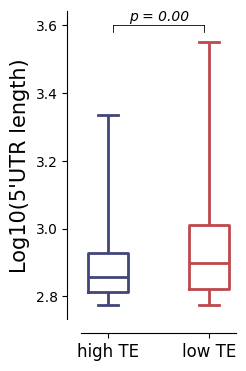

In [35]:
data = pd.DataFrame({'group': ['high TE'] * len(hu_lens) + ['low TE'] * len(lu_lens),
                     'length': hu_lens + lu_lens,})
plt.figure(figsize=(2, 4))
sns.boxplot(data=data[data['group'] == 'high TE'], x='group', y='length', 
            color='#424577', width=0.4, showfliers=False, linewidth=2,fill=False,
            dodge=False, whis=100)
sns.boxplot(data=data[data['group'] == 'low TE'], x='group', y='length',
            color='#bd484d', width=0.4, showfliers=False, linewidth=2,fill=False,
            dodge=False, whis=100)
positions = [0, 1]
ax = plt.gca()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(ticks=positions, labels=['high TE', 'low TE',], fontsize=12)
# plt.yticks([0,1,2,3], fontsize=12)
t_statistic, p_value = ttest_ind(hu_lens, lu_lens)
p_value = p_value / 2 if t_statistic < 0 else 1 - p_value / 2
plt.plot([0.05, 0.95], [3.6,3.6], color='black', lw=0.6);plt.plot([0.05, 0.05], [3.58,3.6], color='black', lw=0.6);plt.plot([0.95, 0.95], [3.58,3.6], color='black', lw=0.6)
plt.annotate(f'p = {p_value:.2f}', xy=(0.5, 0.97), xycoords='axes fraction',
             ha='center', fontsize=10, style='italic')
plt.xlabel("")
plt.ylabel("Log10(5'UTR length)", fontsize=15)
sns.despine()

plt.savefig(f"{path_real}figures/"+'length.pdf', dpi=300, format="pdf", bbox_inches='tight')
plt.show()


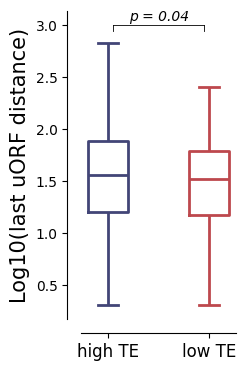

In [36]:
data = pd.DataFrame({'group': ['high TE'] * len(hu_distance) + ['low TE'] * len(lu_distance),
                        'distance': hu_distance + lu_distance})
plt.figure(figsize=(2, 4))
sns.boxplot(data=data[data['group'] == 'high TE'], x='group', y='distance', 
            color='#424577', width=0.4, showfliers=False, linewidth=2,fill=False,
            dodge=False, whis=100)
sns.boxplot(data=data[data['group'] == 'low TE'], x='group', y='distance',
            color='#bd484d', width=0.4, showfliers=False, linewidth=2,fill=False,
            dodge=False, whis=100)
positions = [0, 1]
ax = plt.gca()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(ticks=positions, labels=['high TE', 'low TE',], fontsize=12)
# plt.yticks([0,1,2,3], fontsize=12)
t_statistic, p_value = ttest_ind(hu_distance, lu_distance)
p_value = p_value / 2 if t_statistic > 0 else 1 - p_value / 2
plt.plot([0.05, 0.95], [3,3], color='black', lw=0.6);plt.plot([0.05, 0.05], [2.95,3], color='black', lw=0.6);plt.plot([0.95, 0.95], [2.95,3], color='black', lw=0.6)
plt.annotate(f'p = {p_value:.2f}', xy=(0.5, 0.97), xycoords='axes fraction',
             ha='center', fontsize=10, style='italic')
plt.xlabel("")
plt.ylabel("Log10(last uORF distance)", fontsize=15)
sns.despine()

plt.savefig(f"{path_real}figures/"+'nearORF_distance.pdf', dpi=300, format="pdf", bbox_inches='tight')
plt.show()

In [37]:
from cpmodule import fickett
from cpmodule import FrameKmer
coding = {}
noncoding = {}
hexamer_dat = "../Human_Hexamer.tsv"
for line in open(hexamer_dat, 'r'):
    line = line.strip()
    fields = line.split()
    if fields[0] == 'hexamer':
        continue
    coding[fields[0]] = float(fields[1])
    noncoding[fields[0]] = float(fields[2])

hu_fickett = []; lu_fickett = []
hu_hexamer = []; lu_hexamer = []

for k in high_utr:
    orf = id2all[k]['aa']
    hu_fickett.append(fickett.fickett_value(orf));hu_hexamer.append(FrameKmer.kmer_ratio(orf, 6, 3, coding, noncoding))
for k in low_utr:
    orf = id2all[k]['aa']
    lu_fickett.append(fickett.fickett_value(orf));lu_hexamer.append(FrameKmer.kmer_ratio(orf, 6, 3, coding, noncoding))

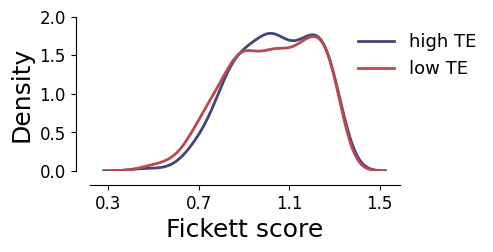

In [38]:
import warnings
warnings.filterwarnings("ignore")
fig,ax = plt.subplots(figsize=(4,2))
sns.distplot(hu_fickett, hist=False, kde_kws={"color": "#424577", "lw": 2, }, label='high TE')
sns.distplot(lu_fickett, hist=False, kde_kws={"color": "#bd484d", "lw": 2, }, label='low TE')
plt.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.legend(loc='upper right', fontsize=13, bbox_to_anchor=(1.3, 1), frameon=False)
ax.set_ylabel("Density", fontsize=18)
ax.set_yticks(np.arange(0, 2.1, 0.5))
ax.set_yticklabels(np.arange(0, 2.1, 0.5), fontsize=12)
ax.set_xticks(np.arange(0.3, 1.6, 0.4))
ax.set_xticklabels([0.3,0.7,1.1,1.5,], fontsize=12)
ax.set_xlabel("Fickett score", fontsize=18)
plt.savefig(f"{path_real}figures/"+'fickett.pdf', dpi=300, format="pdf", bbox_inches='tight')

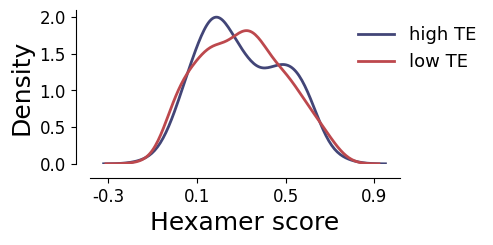

In [39]:
import warnings
warnings.filterwarnings("ignore")
fig,ax = plt.subplots(figsize=(4,2))
sns.distplot(hu_hexamer, hist=False, kde_kws={"color": "#424577", "lw": 2, }, label='high TE')
sns.distplot(lu_hexamer, hist=False, kde_kws={"color": "#bd484d", "lw": 2, }, label='low TE')
plt.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.legend(loc='upper right', fontsize=13, bbox_to_anchor=(1.3, 1), frameon=False)
ax.set_ylabel("Density", fontsize=18)
ax.set_yticks(np.arange(0, 2.1, 0.5))
ax.set_yticklabels(np.arange(0, 2.1, 0.5), fontsize=12)
ax.set_xticks(np.arange(-0.3, 1.1, 0.4))
ax.set_xticklabels([-0.3,0.1,0.5,0.9], fontsize=12)
ax.set_xlabel("Hexamer score", fontsize=18)
plt.savefig(f"{path_real}figures/"+'hexamer.pdf', dpi=300, format="pdf", bbox_inches='tight')